# ECOSTRESS Soil Moisture Data Analysis

Phân tích dữ liệu độ ẩm đất ECOSTRESS với độ phân giải 70m cho dự án bản đồ độ ẩm đất độ phân giải cao.

## Thông tin về dữ liệu:
- **Sản phẩm**: ECOSTRESS Gridded Downscaled Soil Moisture Instantaneous L3 Global 70 m V002
- **Độ phân giải không gian**: 70m
- **Độ phân giải thời gian**: Dữ liệu tức thời từ vệ tinh
- **Phạm vi thời gian**: 1-12/6/2023

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import glob
import os
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Đường dẫn đến thư mục chứa dữ liệu ECOSTRESS
data_dir = "/Users/ninhhaidang/Library/CloudStorage/GoogleDrive-ninhhailongg@gmail.com/My Drive/Cac_mon_hoc/Do_an_tot_nghiep/25-26_HKI_DATN_21021411_DangNH/Data/ECOSTRESS Gridded Downscaled Soil Moisture Instantaneous L3 Global 70 m V002/"

# Lấy danh sách tất cả các file .h5
h5_files = glob.glob(os.path.join(data_dir, "*.h5"))
h5_files.sort()

print(f"Tìm thấy {len(h5_files)} file ECOSTRESS:")
for i, file in enumerate(h5_files):
    filename = os.path.basename(file)
    # Trích xuất ngày từ tên file
    date_str = filename.split('_')[5][:8]
    date_formatted = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}"
    print(f"{i+1}. {filename} ({date_formatted})")

Tìm thấy 4 file ECOSTRESS:
1. ECOv002_L3G_SM_27796_006_20230601T045347_0712_01.h5 (2023-06-01)
2. ECOv002_L3G_SM_27811_005_20230602T040448_0712_01.h5 (2023-06-02)
3. ECOv002_L3G_SM_27857_003_20230605T031507_0712_01.h5 (2023-06-05)
4. ECOv002_L3G_SM_27979_003_20230612T235750_0712_01.h5 (2023-06-12)


## 1. Phân tích metadata và cấu trúc dữ liệu

In [3]:
# Chọn file đầu tiên để phân tích chi tiết
sample_file = h5_files[0]
print(f"Phân tích file mẫu: {os.path.basename(sample_file)}")

def explore_h5_structure(file_path):
    """Khám phá cấu trúc của file HDF5"""
    with h5py.File(file_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}, Shape: {obj.shape}, Dtype: {obj.dtype}")
                if obj.attrs:
                    print(f"  Attributes: {dict(obj.attrs)}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")
        
        print("=== Cấu trúc file HDF5 ===")
        f.visititems(print_structure)

explore_h5_structure(sample_file)

Phân tích file mẫu: ECOv002_L3G_SM_27796_006_20230601T045347_0712_01.h5
=== Cấu trúc file HDF5 ===
Group: HDFEOS
Group: HDFEOS/ADDITIONAL
Group: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
Group: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/AncillaryNWP, Shape: (), Dtype: object
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/BandSpecification, Shape: (6,), Dtype: float32
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/NWPSource, Shape: (), Dtype: object
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/NumberOfBands, Shape: (1,), Dtype: uint8
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/OrbitCorrectionPerformed, Shape: (), Dtype: object
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/QAPercentCloudCover, Shape: (1,), Dtype: int32
Dataset: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/ProductMetadata/QAPercentGoodQuality, Shape: (1,), Dtype: int32
Group: HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/S

In [4]:
# Đọc metadata quan trọng
with h5py.File(sample_file, 'r') as f:
    print("=== METADATA CHÍNH ===")
    
    # Thông tin cơ bản về sản phẩm
    std_meta = f['/HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/StandardMetadata']
    
    important_attrs = [
        'ShortName', 'LongName', 'ProcessingLevelID',
        'ImageLines', 'ImagePixels', 'ImageLineSpacing', 'ImagePixelSpacing',
        'NorthBoundingCoordinate', 'SouthBoundingCoordinate',
        'EastBoundingCoordinate', 'WestBoundingCoordinate',
        'RangeBeginningDate', 'RangeBeginningTime'
    ]
    
    for attr in important_attrs:
        if attr in std_meta:
            value = std_meta[attr][()]
            if isinstance(value, bytes):
                value = value.decode('utf-8')
            print(f"{attr}: {value}")
    
    print("\n=== THÔNG TIN VỀ DATASET SOIL MOISTURE ===")
    sm_dataset = f['/HDFEOS/GRIDS/ECO_L3G_SM_70m/Data Fields/SM']
    print(f"Shape: {sm_dataset.shape}")
    print(f"Data type: {sm_dataset.dtype}")
    print(f"Attributes: {dict(sm_dataset.attrs)}")

=== METADATA CHÍNH ===
ShortName: ECO_L3G_SM
LongName: ECOSTRESS Gridded Downscaled Soil Moisture Instantaneous L3 Global 70 m
ProcessingLevelID: L3G
ImageLines: [6953]
ImagePixels: [7787]
ImageLineSpacing: [0.0007]
ImagePixelSpacing: [0.0007]
NorthBoundingCoordinate: [25.6858]
SouthBoundingCoordinate: [20.8187]
EastBoundingCoordinate: [107.2225]
WestBoundingCoordinate: [101.7716]
RangeBeginningDate: 2023-06-01
RangeBeginningTime: 04:53:47.419010

=== THÔNG TIN VỀ DATASET SOIL MOISTURE ===
Shape: (6953, 7787)
Data type: float32
Attributes: {}


## 2. Đọc và phân tích dữ liệu độ ẩm đất

In [5]:
def read_ecostress_data(file_path):
    """Đọc dữ liệu ECOSTRESS từ file HDF5"""
    data = {}
    
    with h5py.File(file_path, 'r') as f:
        # Đọc dữ liệu độ ẩm đất
        data['SM'] = f['/HDFEOS/GRIDS/ECO_L3G_SM_70m/Data Fields/SM'][:]
        data['cloud'] = f['/HDFEOS/GRIDS/ECO_L3G_SM_70m/Data Fields/cloud'][:]
        data['water'] = f['/HDFEOS/GRIDS/ECO_L3G_SM_70m/Data Fields/water'][:]
        
        # Đọc metadata
        std_meta = f['/HDFEOS/ADDITIONAL/FILE_ATTRIBUTES/StandardMetadata']
        data['metadata'] = {}
        for key in std_meta.keys():
            value = std_meta[key][()]
            if isinstance(value, bytes):
                value = value.decode('utf-8')
            data['metadata'][key] = value
            
        # Đọc attributes của SM dataset
        sm_attrs = dict(f['/HDFEOS/GRIDS/ECO_L3G_SM_70m/Data Fields/SM'].attrs)
        data['SM_attributes'] = {}
        for key, value in sm_attrs.items():
            if isinstance(value, bytes):
                value = value.decode('utf-8')
            elif isinstance(value, np.ndarray) and value.dtype.char == 'S':
                value = value.astype(str)
            data['SM_attributes'][key] = value
    
    return data

# Đọc dữ liệu từ file mẫu
sample_data = read_ecostress_data(sample_file)

print("=== THÔNG TIN DỮ LIỆU ===")
print(f"Soil Moisture shape: {sample_data['SM'].shape}")
print(f"Cloud mask shape: {sample_data['cloud'].shape}")
print(f"Water mask shape: {sample_data['water'].shape}")

print("\n=== SOIL MOISTURE ATTRIBUTES ===")
for key, value in sample_data['SM_attributes'].items():
    print(f"{key}: {value}")

=== THÔNG TIN DỮ LIỆU ===
Soil Moisture shape: (6953, 7787)
Cloud mask shape: (6953, 7787)
Water mask shape: (6953, 7787)

=== SOIL MOISTURE ATTRIBUTES ===


In [6]:
# Phân tích thống kê cơ bản của dữ liệu độ ẩm đất
sm_data = sample_data['SM']
cloud_data = sample_data['cloud']
water_data = sample_data['water']

print("=== THỐNG KÊ DỮ LIỆU SOIL MOISTURE ===")
print(f"Min value: {np.min(sm_data)}")
print(f"Max value: {np.max(sm_data)}")
print(f"Mean: {np.mean(sm_data):.4f}")
print(f"Std: {np.std(sm_data):.4f}")
print(f"Unique values count: {len(np.unique(sm_data))}")

# Kiểm tra giá trị đặc biệt (fill values, no data)
print("\n=== PHÂN TÍCH GIÁ TRỊ ĐẶC BIỆT ===")
unique_values = np.unique(sm_data)
print(f"Tất cả giá trị unique (10 đầu và 10 cuối):")
print(f"Đầu: {unique_values[:10]}")
print(f"Cuối: {unique_values[-10:]}")

# Kiểm tra fill value từ attributes
if '_FillValue' in sample_data['SM_attributes']:
    fill_value = sample_data['SM_attributes']['_FillValue']
    print(f"Fill value từ metadata: {fill_value}")
    valid_data = sm_data[sm_data != fill_value]
    print(f"Số pixel hợp lệ: {len(valid_data)} / {sm_data.size} ({len(valid_data)/sm_data.size*100:.2f}%)")
    if len(valid_data) > 0:
        print(f"Valid data range: {np.min(valid_data):.4f} - {np.max(valid_data):.4f}")
        print(f"Valid data mean: {np.mean(valid_data):.4f}")

=== THỐNG KÊ DỮ LIỆU SOIL MOISTURE ===
Min value: nan
Max value: nan
Mean: nan
Std: nan
Unique values count: 11709223

=== PHÂN TÍCH GIÁ TRỊ ĐẶC BIỆT ===
Tất cả giá trị unique (10 đầu và 10 cuối):
Đầu: [0.00000000e+00 1.39641008e-06 3.65450978e-06 4.73577529e-06
 1.21626526e-05 1.27954545e-05 1.88816339e-05 2.17660636e-05
 2.19605863e-05 2.24001706e-05]
Cuối: [0.9986131  0.9987098  0.99872595 0.9988065  0.99882233 0.99890316
 0.9989187  0.99899983 1.                nan]


## 3. Trực quan hóa dữ liệu

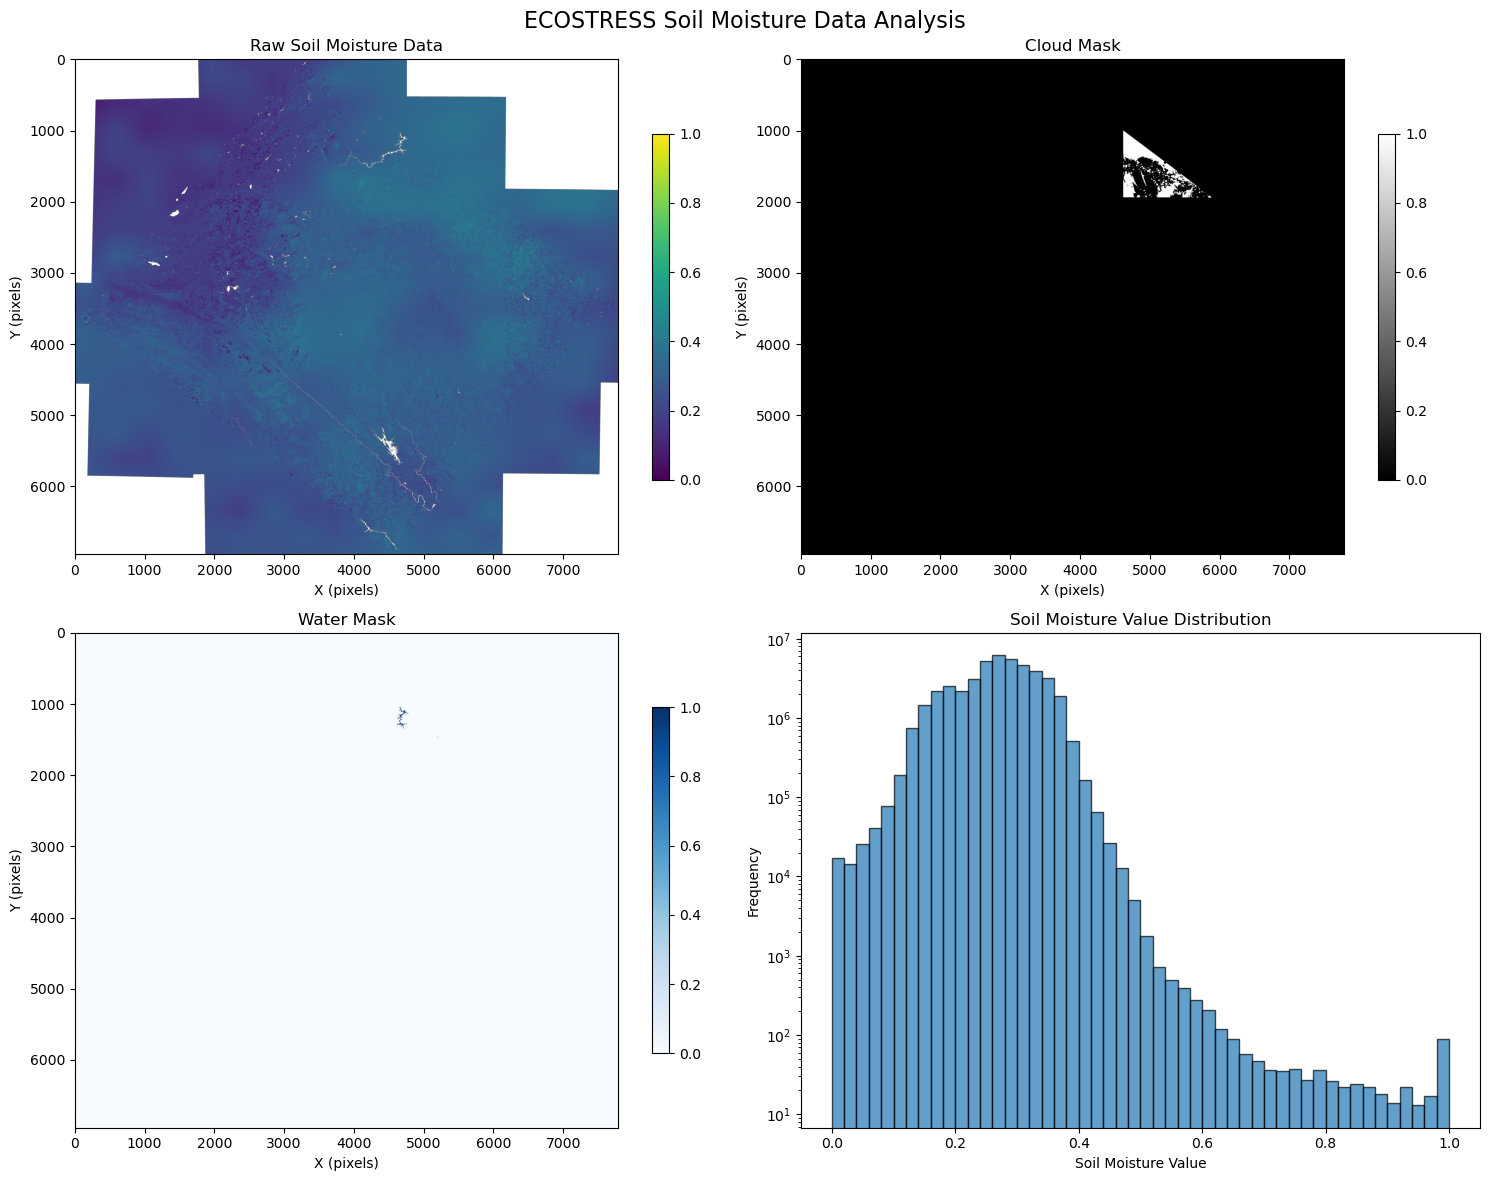

In [7]:
# Trực quan hóa dữ liệu soil moisture
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ECOSTRESS Soil Moisture Data Analysis', fontsize=16)

# 1. Raw soil moisture data
im1 = axes[0,0].imshow(sm_data, cmap='viridis', aspect='auto')
axes[0,0].set_title('Raw Soil Moisture Data')
axes[0,0].set_xlabel('X (pixels)')
axes[0,0].set_ylabel('Y (pixels)')
plt.colorbar(im1, ax=axes[0,0], shrink=0.7)

# 2. Cloud mask
im2 = axes[0,1].imshow(cloud_data, cmap='gray', aspect='auto')
axes[0,1].set_title('Cloud Mask')
axes[0,1].set_xlabel('X (pixels)')
axes[0,1].set_ylabel('Y (pixels)')
plt.colorbar(im2, ax=axes[0,1], shrink=0.7)

# 3. Water mask
im3 = axes[1,0].imshow(water_data, cmap='Blues', aspect='auto')
axes[1,0].set_title('Water Mask')
axes[1,0].set_xlabel('X (pixels)')
axes[1,0].set_ylabel('Y (pixels)')
plt.colorbar(im3, ax=axes[1,0], shrink=0.7)

# 4. Histogram của soil moisture
axes[1,1].hist(sm_data.flatten(), bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Soil Moisture Value Distribution')
axes[1,1].set_xlabel('Soil Moisture Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

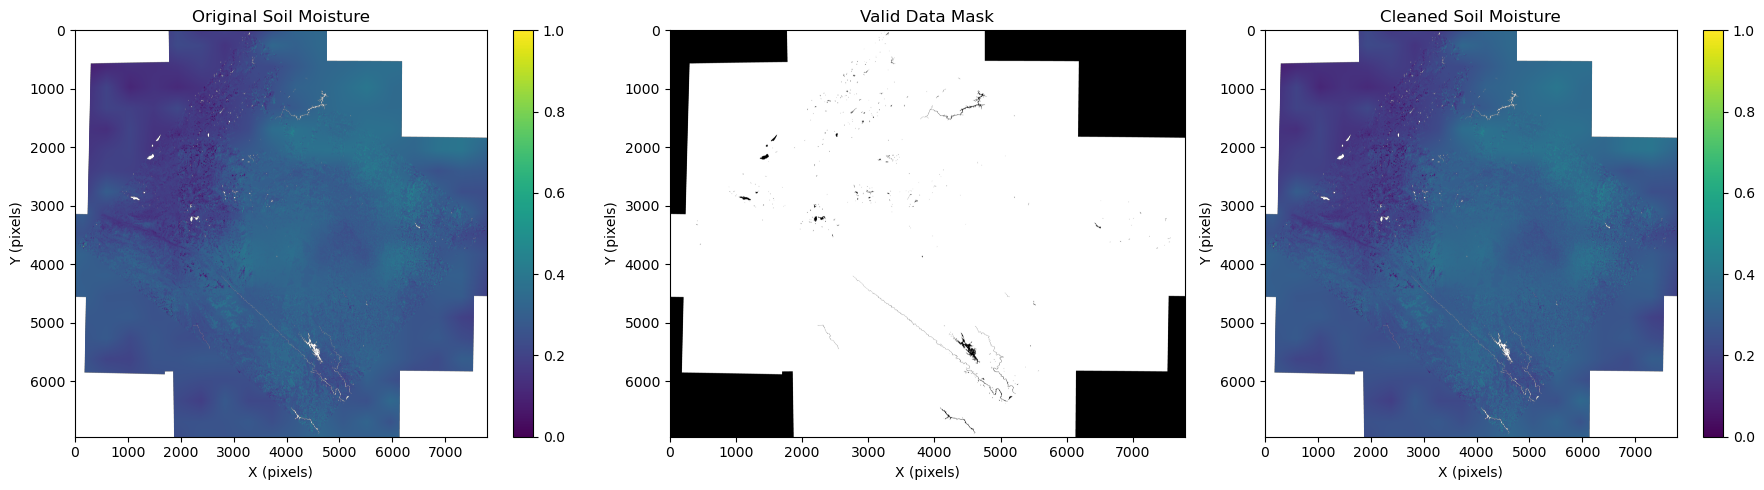

Tỷ lệ dữ liệu hợp lệ: 81.47%


In [8]:
# Tạo mask để loại bỏ dữ liệu không hợp lệ
def create_valid_mask(sm_data, fill_value=None):
    """Tạo mask cho dữ liệu hợp lệ"""
    valid_mask = np.ones(sm_data.shape, dtype=bool)
    
    if fill_value is not None:
        valid_mask &= (sm_data != fill_value)
    
    # Loại bỏ giá trị âm (thường là no data)
    valid_mask &= (sm_data >= 0)
    
    # Loại bỏ giá trị quá lớn (có thể là lỗi)
    valid_mask &= (sm_data <= 1.0)  # Giả sử soil moisture trong khoảng 0-1
    
    return valid_mask

# Tạo mask và áp dụng
fill_value = sample_data['SM_attributes'].get('_FillValue', -9999)
valid_mask = create_valid_mask(sm_data, fill_value)

# Trực quan hóa dữ liệu đã được làm sạch
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Original data
im1 = axes[0].imshow(sm_data, cmap='viridis', aspect='auto')
axes[0].set_title('Original Soil Moisture')
plt.colorbar(im1, ax=axes[0])

# 2. Valid mask
axes[1].imshow(valid_mask, cmap='gray', aspect='auto')
axes[1].set_title('Valid Data Mask')

# 3. Cleaned data
cleaned_data = np.where(valid_mask, sm_data, np.nan)
im3 = axes[2].imshow(cleaned_data, cmap='viridis', aspect='auto')
axes[2].set_title('Cleaned Soil Moisture')
plt.colorbar(im3, ax=axes[2])

for ax in axes:
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.show()

print(f"Tỷ lệ dữ liệu hợp lệ: {np.sum(valid_mask) / valid_mask.size * 100:.2f}%")

## 4. Phân tích tất cả các file

In [9]:
# Phân tích tất cả các file để hiểu xu hướng thời gian
file_info = []

for file_path in h5_files:
    try:
        data = read_ecostress_data(file_path)
        sm_data = data['SM']
        
        # Trích xuất thông tin từ tên file
        filename = os.path.basename(file_path)
        date_str = filename.split('_')[5][:8]
        date_obj = datetime.strptime(date_str, '%Y%m%d')
        
        # Tính toán thống kê
        fill_value = data['SM_attributes'].get('_FillValue', -9999)
        valid_mask = create_valid_mask(sm_data, fill_value)
        valid_data = sm_data[valid_mask]
        
        info = {
            'filename': filename,
            'date': date_obj,
            'date_str': date_str,
            'total_pixels': sm_data.size,
            'valid_pixels': len(valid_data),
            'valid_ratio': len(valid_data) / sm_data.size * 100,
            'sm_mean': np.mean(valid_data) if len(valid_data) > 0 else np.nan,
            'sm_std': np.std(valid_data) if len(valid_data) > 0 else np.nan,
            'sm_min': np.min(valid_data) if len(valid_data) > 0 else np.nan,
            'sm_max': np.max(valid_data) if len(valid_data) > 0 else np.nan,
            'bounds': {
                'north': float(data['metadata'].get('NorthBoundingCoordinate', np.nan)),
                'south': float(data['metadata'].get('SouthBoundingCoordinate', np.nan)),
                'east': float(data['metadata'].get('EastBoundingCoordinate', np.nan)),
                'west': float(data['metadata'].get('WestBoundingCoordinate', np.nan))
            }
        }
        
        file_info.append(info)
        
    except Exception as e:
        print(f"Lỗi khi xử lý file {os.path.basename(file_path)}: {e}")

# Tạo DataFrame để dễ phân tích
df = pd.DataFrame(file_info)
df = df.sort_values('date')

print("=== TỔNG QUAN TẤT CẢ CÁC FILE ===")
print(df[['filename', 'date_str', 'valid_ratio', 'sm_mean', 'sm_std']].round(4))

=== TỔNG QUAN TẤT CẢ CÁC FILE ===
                                            filename  date_str  valid_ratio  \
0  ECOv002_L3G_SM_27796_006_20230601T045347_0712_...  20230601      81.4673   
1  ECOv002_L3G_SM_27811_005_20230602T040448_0712_...  20230602      39.2563   
2  ECOv002_L3G_SM_27857_003_20230605T031507_0712_...  20230605      81.3297   
3  ECOv002_L3G_SM_27979_003_20230612T235750_0712_...  20230612      31.2180   

   sm_mean  sm_std  
0   0.2691  0.0634  
1   0.3518  0.2103  
2   0.3286  0.0842  
3   0.3145  0.0470  


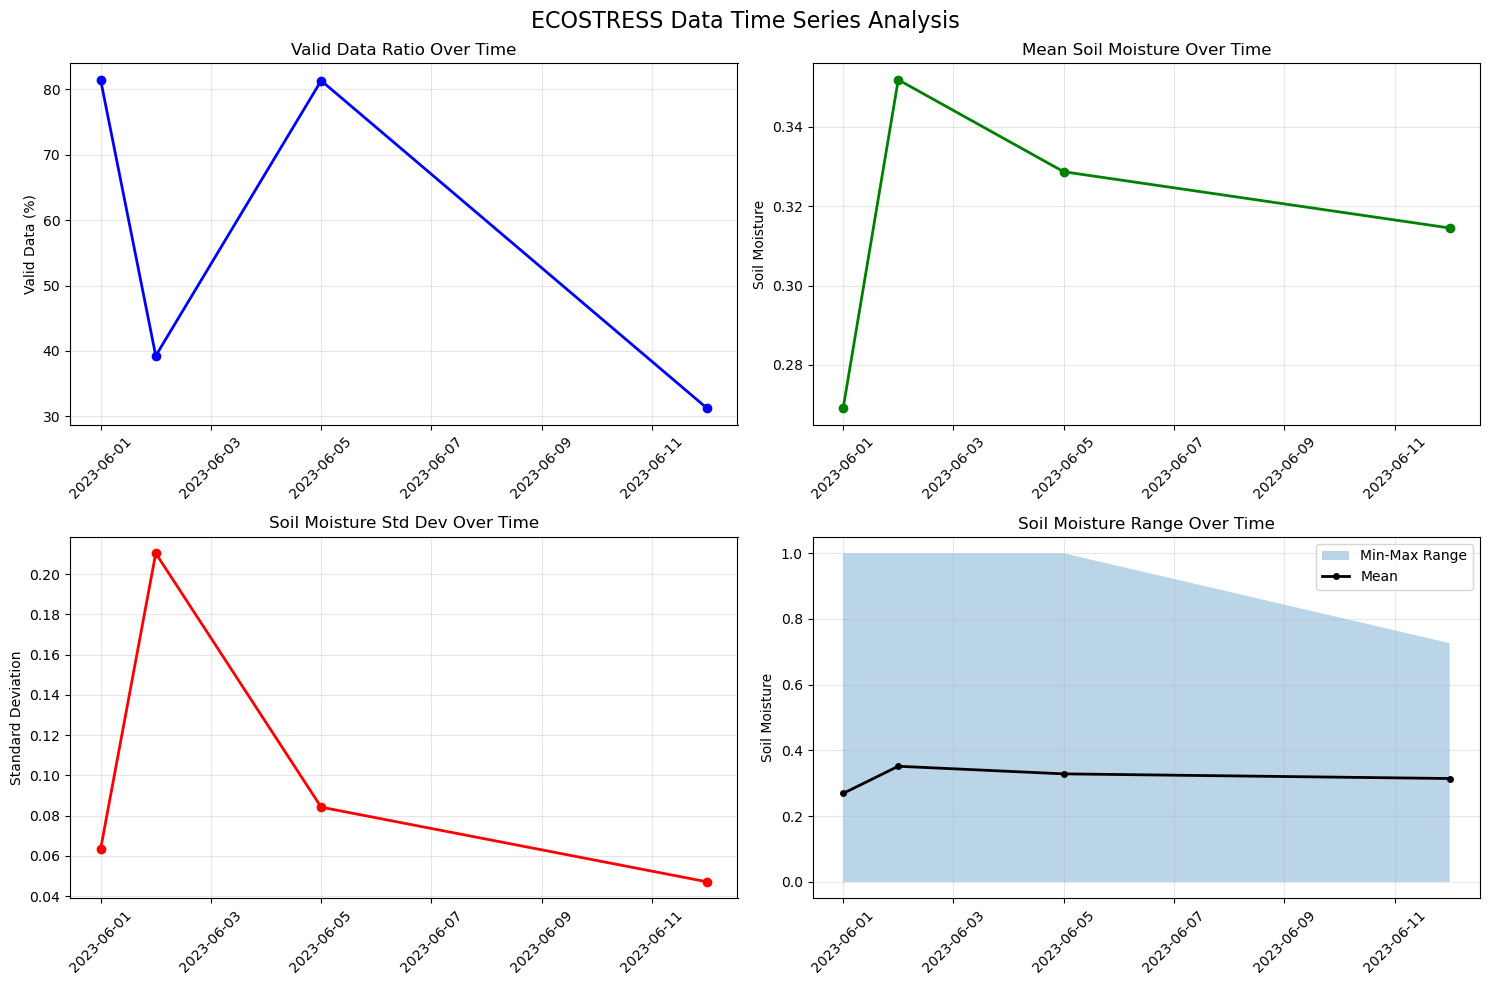

In [10]:
# Trực quan hóa xu hướng thời gian
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ECOSTRESS Data Time Series Analysis', fontsize=16)

# 1. Tỷ lệ dữ liệu hợp lệ theo thời gian
axes[0,0].plot(df['date'], df['valid_ratio'], 'b-o', linewidth=2, markersize=6)
axes[0,0].set_title('Valid Data Ratio Over Time')
axes[0,0].set_ylabel('Valid Data (%)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Giá trị trung bình soil moisture theo thời gian
axes[0,1].plot(df['date'], df['sm_mean'], 'g-o', linewidth=2, markersize=6)
axes[0,1].set_title('Mean Soil Moisture Over Time')
axes[0,1].set_ylabel('Soil Moisture')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Độ lệch chuẩn theo thời gian
axes[1,0].plot(df['date'], df['sm_std'], 'r-o', linewidth=2, markersize=6)
axes[1,0].set_title('Soil Moisture Std Dev Over Time')
axes[1,0].set_ylabel('Standard Deviation')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Min-Max range theo thời gian
axes[1,1].fill_between(df['date'], df['sm_min'], df['sm_max'], alpha=0.3, label='Min-Max Range')
axes[1,1].plot(df['date'], df['sm_mean'], 'k-o', linewidth=2, markersize=4, label='Mean')
axes[1,1].set_title('Soil Moisture Range Over Time')
axes[1,1].set_ylabel('Soil Moisture')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Phân tích phạm vi địa lý

In [11]:
# Phân tích phạm vi địa lý của dữ liệu
print("=== THÔNG TIN ĐỊA LÝ ===")

for idx, row in df.iterrows():
    bounds = row['bounds']
    print(f"\nFile: {row['filename']}")
    print(f"  North: {bounds['north']:.6f}°")
    print(f"  South: {bounds['south']:.6f}°")
    print(f"  East:  {bounds['east']:.6f}°")
    print(f"  West:  {bounds['west']:.6f}°")
    print(f"  Lat range: {bounds['north'] - bounds['south']:.6f}°")
    print(f"  Lon range: {bounds['east'] - bounds['west']:.6f}°")

# Kiểm tra xem tất cả các file có cùng phạm vi không
print("\n=== KIỂM TRA TÍNH NHẤT QUÁN ĐỊA LÝ ===")
bounds_df = pd.DataFrame([row['bounds'] for _, row in df.iterrows()])
print("Thống kê bounds:")
print(bounds_df.describe())

# Kiểm tra xem có file nào khác biệt không
tolerance = 1e-6
consistent = True
for col in ['north', 'south', 'east', 'west']:
    if bounds_df[col].std() > tolerance:
        print(f"CẢNH BÁO: {col} không nhất quán giữa các file")
        consistent = False

if consistent:
    print("✓ Tất cả các file có cùng phạm vi địa lý")
else:
    print("⚠ Có sự khác biệt về phạm vi địa lý giữa các file")

=== THÔNG TIN ĐỊA LÝ ===

File: ECOv002_L3G_SM_27796_006_20230601T045347_0712_01.h5
  North: 25.685800°
  South: 20.818700°
  East:  107.222500°
  West:  101.771600°
  Lat range: 4.867100°
  Lon range: 5.450900°

File: ECOv002_L3G_SM_27811_005_20230602T040448_0712_01.h5
  North: 21.961100°
  South: 17.107300°
  East:  110.103000°
  West:  104.795600°
  Lat range: 4.853800°
  Lon range: 5.307400°

File: ECOv002_L3G_SM_27857_003_20230605T031507_0712_01.h5
  North: 24.383100°
  South: 19.522300°
  East:  107.226700°
  West:  101.832500°
  Lat range: 4.860800°
  Lon range: 5.394200°

File: ECOv002_L3G_SM_27979_003_20230612T235750_0712_01.h5
  North: 25.509400°
  South: 20.630400°
  East:  110.946500°
  West:  105.486500°
  Lat range: 4.879000°
  Lon range: 5.460000°

=== KIỂM TRA TÍNH NHẤT QUÁN ĐỊA LÝ ===
Thống kê bounds:
           north      south        east        west
count   4.000000   4.000000    4.000000    4.000000
mean   24.384850  19.519675  108.874675  103.471550
std     1.7157

## 6. Đánh giá chất lượng và khuyến nghị

In [12]:
print("=== ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU ===")

# 1. Tỷ lệ dữ liệu hợp lệ
mean_valid_ratio = df['valid_ratio'].mean()
print(f"\n1. TỶ LỆ DỮ LIỆU HỢP LỆ:")
print(f"   - Trung bình: {mean_valid_ratio:.2f}%")
print(f"   - Thấp nhất: {df['valid_ratio'].min():.2f}%")
print(f"   - Cao nhất: {df['valid_ratio'].max():.2f}%")

if mean_valid_ratio > 50:
    print("   ✓ Tỷ lệ dữ liệu hợp lệ tốt")
elif mean_valid_ratio > 20:
    print("   ⚠ Tỷ lệ dữ liệu hợp lệ trung bình")
else:
    print("   ✗ Tỷ lệ dữ liệu hợp lệ thấp")

# 2. Tính nhất quán của dữ liệu
sm_mean_std = df['sm_mean'].std()
print(f"\n2. TÍNH NHẤT QUÁN:")
print(f"   - Độ lệch chuẩn của mean SM giữa các ngày: {sm_mean_std:.6f}")
print(f"   - Phạm vi mean SM: {df['sm_mean'].min():.4f} - {df['sm_mean'].max():.4f}")

# 3. Phân bố thời gian
time_gaps = df['date'].diff().dt.days.dropna()
print(f"\n3. PHÂN BỐ THỜI GIAN:")
print(f"   - Khoảng thời gian: {df['date'].min().strftime('%Y-%m-%d')} đến {df['date'].max().strftime('%Y-%m-%d')}")
print(f"   - Số ngày: {len(df)}")
print(f"   - Khoảng cách trung bình giữa các quan sát: {time_gaps.mean():.1f} ngày")

# 4. Thông tin về độ phân giải
sample_info = df.iloc[0]
total_pixels = sample_info['total_pixels']
print(f"\n4. ĐỘ PHÂN GiẢI:")
print(f"   - Tổng số pixel mỗi file: {total_pixels:,}")
print(f"   - Độ phân giải không gian: 70m")
print(f"   - Kích thước ảnh: {int(np.sqrt(total_pixels))} x {int(np.sqrt(total_pixels))} (ước tính)")

print("\n" + "="*50)
print("KHUYẾN NGHỊ CHO DỰ ÁN CỦA BẠN:")
print("="*50)

print("\n🎯 ƯU ĐIỂM CỦA DỮ LIỆU ECOSTRESS:")
print("   • Độ phân giải không gian cao (70m) - rất phù hợp cho bản đồ chi tiết")
print("   • Dữ liệu đã được xử lý và hiệu chỉnh (Level 3)")
print("   • Có sẵn mask cho cloud và water")
print("   • Định dạng HDF5 chuẩn, dễ xử lý")

print("\n⚠️  HẠN CHẾ CẦN LƯU Ý:")
if mean_valid_ratio < 50:
    print(f"   • Tỷ lệ dữ liệu hợp lệ chỉ {mean_valid_ratio:.1f}% - có thể do mây che phủ")
print("   • Dữ liệu không liên tục (chỉ khi vệ tinh bay qua)")
print("   • Phạm vi không gian hạn chế (chỉ một khu vực nhỏ)")
print("   • Có thể bị ảnh hưởng bởi điều kiện thời tiết")


print("\n📋 CÁC BƯỚC XỬ LÝ ĐỀ XUẤT:")
print("\n1. TIỀN XỬ LÝ:")
print("   • Áp dụng quality mask (loại bỏ cloud, water pixels)")
print("   • Kiểm tra và xử lý outliers")
print("   • Chuẩn hóa giá trị soil moisture về thang 0-1")

print("\n2. PHÂN TÍCH KHÔNG GIAN:")
print("   • Tạo composite từ multiple dates để giảm missing data")
print("   • Áp dụng spatial interpolation cho missing pixels")
print("   • Phân tích mẫu không gian của soil moisture")

print("\n3. PHÂN TÍCH THỜI GIAN:")
print("   • So sánh soil moisture giữa các ngày")
print("   • Xác định trend và seasonal patterns")
print("   • Tương quan với dữ liệu khí tượng (nếu có)")

print("\n4. TÍCH HỢP VỚI DỮ LIỆU KHÁC:")
print("   • Kết hợp với Sentinel-1, Sentinel-2 trong cùng thư mục")
print("   • Sử dụng SMAP data làm reference/validation")
print("   • Áp dụng machine learning để nâng cao độ chính xác")

print("\n5. TẠO BẢN ĐỒ CUỐI CÙNG:")
print("   • Sử dụng GIS software để tạo bản đồ chuyên nghiệp")
print("   • Thêm legend, scale bar, coordinate system")
print("   • Export với format phù hợp (GeoTIFF, PNG, PDF)")

=== ĐÁNH GIÁ CHẤT LƯỢNG DỮ LIỆU ===

1. TỶ LỆ DỮ LIỆU HỢP LỆ:
   - Trung bình: 58.32%
   - Thấp nhất: 31.22%
   - Cao nhất: 81.47%
   ✓ Tỷ lệ dữ liệu hợp lệ tốt

2. TÍNH NHẤT QUÁN:
   - Độ lệch chuẩn của mean SM giữa các ngày: 0.034859
   - Phạm vi mean SM: 0.2691 - 0.3518

3. PHÂN BỐ THỜI GIAN:
   - Khoảng thời gian: 2023-06-01 đến 2023-06-12
   - Số ngày: 4
   - Khoảng cách trung bình giữa các quan sát: 3.7 ngày

4. ĐỘ PHÂN GiẢI:
   - Tổng số pixel mỗi file: 54,143,011
   - Độ phân giải không gian: 70m
   - Kích thước ảnh: 7358 x 7358 (ước tính)

KHUYẾN NGHỊ CHO DỰ ÁN CỦA BẠN:

🎯 ƯU ĐIỂM CỦA DỮ LIỆU ECOSTRESS:
   • Độ phân giải không gian cao (70m) - rất phù hợp cho bản đồ chi tiết
   • Dữ liệu đã được xử lý và hiệu chỉnh (Level 3)
   • Có sẵn mask cho cloud và water
   • Định dạng HDF5 chuẩn, dễ xử lý

⚠️  HẠN CHẾ CẦN LƯU Ý:
   • Dữ liệu không liên tục (chỉ khi vệ tinh bay qua)
   • Phạm vi không gian hạn chế (chỉ một khu vực nhỏ)
   • Có thể bị ảnh hưởng bởi điều kiện thời tiết

📋 